# Capstone Project - The Battle of Neighborhoods (Week 2)

## The mission of this recommendation system is to find the best possible restaurant by type. This system will provide visitors with a list of related restaurants located in featured area (most popular location of a specific type of restaurant) in Manhattan.

### Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import re

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  2.2.3
Libraries imported.


### Import data

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [5]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Select data (information) for Manhattan, NY

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan']
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
address = 'Manhattan, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

C:\Users\jiaoa\Anaconda3\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


40.7900869 -73.9598295


In [8]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)
map_manhattan

### Input Foursquare API account information for data extraction

In [9]:
CLIENT_ID = '2NORNKRIJM3DPRJ0MOMH5EMCYCOFNKUKKMKSABO2BC0XQOBI' # your Foursquare ID
CLIENT_SECRET = 'XGN1WCZ3QE0CD53HKF0HE2IKAYD4PXXVFJ54ZAM5EJPBQJA2' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 2000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2NORNKRIJM3DPRJ0MOMH5EMCYCOFNKUKKMKSABO2BC0XQOBI
CLIENT_SECRET:XGN1WCZ3QE0CD53HKF0HE2IKAYD4PXXVFJ54ZAM5EJPBQJA2


### Define search criteria of restaurant

In [10]:
search_query = 'Restaurant'
radius = 1000
print(search_query + ' .... OK!')

Restaurant .... OK!


### Extract identification and location information

In [11]:
def getNearbyVenues(boroughs, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    counter = 0

    for borough, lat, lng in zip(boroughs, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        tmp_dict = {}
        tmp_dict['Borough'] = borough;
        tmp_dict['Latitude'] = lat; tmp_dict['Longitude'] = lng;
        tmp_dict['Crawling_result'] = results;
        venues_list.append(tmp_dict)
        counter += 1
        print('{}.'.format(counter),tmp_dict['Borough'],tmp_dict['Latitude'],tmp_dict['Longitude'])
        
    return(venues_list)

In [12]:
nyc_venues = getNearbyVenues(boroughs=manhattan_data['Borough'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

1. Manhattan 40.87655077879964 -73.91065965862981
2. Manhattan 40.71561842231432 -73.99427936255978
3. Manhattan 40.85190252555305 -73.93690027985234
4. Manhattan 40.86768396449915 -73.92121042203897
5. Manhattan 40.823604284811935 -73.94968791883366
6. Manhattan 40.8169344294978 -73.9573853935188
7. Manhattan 40.81597606742414 -73.94321112603905
8. Manhattan 40.79224946663033 -73.94418223148524
9. Manhattan 40.775638573301805 -73.96050763135
10. Manhattan 40.775929849884875 -73.94711784471826
11. Manhattan 40.76811265828733 -73.9588596881376
12. Manhattan 40.76215960576283 -73.94916769227953
13. Manhattan 40.787657998534854 -73.97705923630603
14. Manhattan 40.77352888942166 -73.98533777001262
15. Manhattan 40.75910089146212 -73.99611936309479
16. Manhattan 40.75469110270623 -73.98166882730304
17. Manhattan 40.748303077252174 -73.97833207924127
18. Manhattan 40.744034706747975 -74.00311633472813
19. Manhattan 40.72693288536128 -73.99991402945902
20. Manhattan 40.727846777270244 -73.982

### Clean the data extracted to dataframe format

In [13]:
# This function is created to connect to the saved list which is the received database. It will extract each venue 
# for every neighborhood inside the database

def cleanVenue(database):
    result_df = pd.DataFrame(columns = ['Borough', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Address',
                  'Venue Zipcode',
                  'Venue Category'])

    for borough_dict in database:
        Borough = borough_dict['Borough']; LAT = borough_dict['Latitude']; LNG = borough_dict['Longitude']
        print(len(borough_dict['Crawling_result'])) 
        
        for venue_dict  in borough_dict['Crawling_result']:
            ID = venue_dict ['venue']['id']
            Name = venue_dict ['venue']['name']
            Latitude = venue_dict ['venue']['location']['lat']
            Longtitude = venue_dict ['venue']['location']['lng']
            Address = venue_dict ['venue']['location']['formattedAddress']
            try:
                Zipcode = re.search(r'\d{5}(?:-\d{4})?(?=\D*$)', str(Address)).group()
            except:
                Zipcode = "None"
            Category =  venue_dict ['venue']['categories'][0]['name']

            result_df = result_df.append({'Borough': Borough, 'Venue ID': ID, 'Venue': Name,
                                'Venue Latitude': Latitude, 'Venue Longitude': Longtitude,
                                'Venue Address': Address, 'Venue Zipcode': Zipcode,
                                'Venue Category': Category,}, ignore_index = True)
            

    return(result_df)

In [14]:
nyc_vl = cleanVenue(nyc_venues)

13
100
71
50
59
42
47
51
80
84
100
11
56
50
100
100
100
100
100
100
41
62
100
100
100
44
40
57
41
100
68
100
86
100
85
88
83
3
100
41


In [15]:
nyc_vl.head()

,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category
0,Manhattan,4b4429abf964a52037f225e3,Arturo's,40.874412,-73.910271,"[5198 Broadway (at 225th St.), New York, NY 10...",10463,Pizza Place
1,Manhattan,4b79cc46f964a520c5122fe3,Tibbett Diner,40.880404,-73.908937,"[3033 Tibbett Ave (btwn 230th & 231st), Bronx,...",10463,Diner
2,Manhattan,4b5357adf964a520319827e3,Dunkin' Donuts,40.876993,-73.906507,"[5501 Broadway (W 230th St), Bronx, NY 10463, ...",10463,Donut Shop
3,Manhattan,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,"[5535 Broadway (231st St), Bronx, NY 10463, Un...",10463,Seafood Restaurant
4,Manhattan,4dfe40df8877333e195b68fc,Parrilla Latina,40.877473,-73.906073,"[230th St & Broadway, Bronx, NY 10463, United ...",10463,Steakhouse


### Filter and specify venues to be "Restaurant" instead of other food shop

In [16]:
nyc_restaurant = nyc_vl[nyc_vl['Venue Category'].str.contains("Restaurant")]
nyc_restaurant = pd.DataFrame(nyc_restaurant)
nyc_restaurant['Restaurant Type'] = nyc_restaurant['Venue Category']
nyc_restaurant['Restaurant Type'] = nyc_restaurant['Restaurant Type'].map(lambda x: x.rstrip('Restaurant'))
nyc_restaurant['Restaurant Type'].replace('', 'General', inplace=True)
nyc_restaurant.head()

,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category,Restaurant Type
3,Manhattan,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,"[5535 Broadway (231st St), Bronx, NY 10463, Un...",10463,Seafood Restaurant,Seafood
5,Manhattan,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,"[5520 Broadway, Bronx, NY 10463, United States]",10463,American Restaurant,American
10,Manhattan,4b5e451cf964a520f58629e3,Applebee's Grill + Bar,40.873685,-73.908928,"[76 W 225th St (Broadway), Bronx, NY 10463, Un...",10463,Restaurant,General
11,Manhattan,52411ca98bbd75ed0f690c1f,Kingsbridge-Riverdale Farmers' Market,40.879394,-73.907125,"[260 W 231st St (Kingsbridge Ave.), Bronx, NY ...",10463,Vegetarian / Vegan Restaurant,Vegetarian / Vegan
12,Manhattan,5012c967e889cf0567e9e2d4,Grill 26 at TCR,40.878802,-73.915672,"[2600 Netherland Ave (off Kappock Street), Bro...",10463,American Restaurant,American


In [17]:
nyc_restaurant = pd.DataFrame(nyc_restaurant)
nyc_restaurant['Restaurant Type'] = nyc_restaurant['Venue Category']
nyc_restaurant['Restaurant Type'] = nyc_restaurant['Restaurant Type'].map(lambda x: x.rstrip('Restaurant'))
nyc_restaurant['Restaurant Type'].replace('', 'General', inplace=True)
nyc_restaurant.head()

,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category,Restaurant Type
3,Manhattan,4b9c9c6af964a520b27236e3,Land & Sea Restaurant,40.877885,-73.905873,"[5535 Broadway (231st St), Bronx, NY 10463, Un...",10463,Seafood Restaurant,Seafood
5,Manhattan,585c205665e7c70a2f1055ea,Boston Market,40.877430,-73.905412,"[5520 Broadway, Bronx, NY 10463, United States]",10463,American Restaurant,American
10,Manhattan,4b5e451cf964a520f58629e3,Applebee's Grill + Bar,40.873685,-73.908928,"[76 W 225th St (Broadway), Bronx, NY 10463, Un...",10463,Restaurant,General
11,Manhattan,52411ca98bbd75ed0f690c1f,Kingsbridge-Riverdale Farmers' Market,40.879394,-73.907125,"[260 W 231st St (Kingsbridge Ave.), Bronx, NY ...",10463,Vegetarian / Vegan Restaurant,Vegetarian / Vegan
12,Manhattan,5012c967e889cf0567e9e2d4,Grill 26 at TCR,40.878802,-73.915672,"[2600 Netherland Ave (off Kappock Street), Bro...",10463,American Restaurant,American


### Visualize the most popular restaurant types in Manhattan

In [18]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Wordcloud is installed and imported!


In [19]:
nyc_words = nyc_restaurant['Restaurant Type']
nyc_words.to_csv('NYC_words.txt', sep=',', index=False)

In [20]:
WORDS = open('NYC_words.txt', 'r').read()
stopwords = set(STOPWORDS)
nyc_wc = WordCloud(
background_color='white',
    max_words=2000,
    stopwords=stopwords
)

nyc_wc.generate(WORDS)

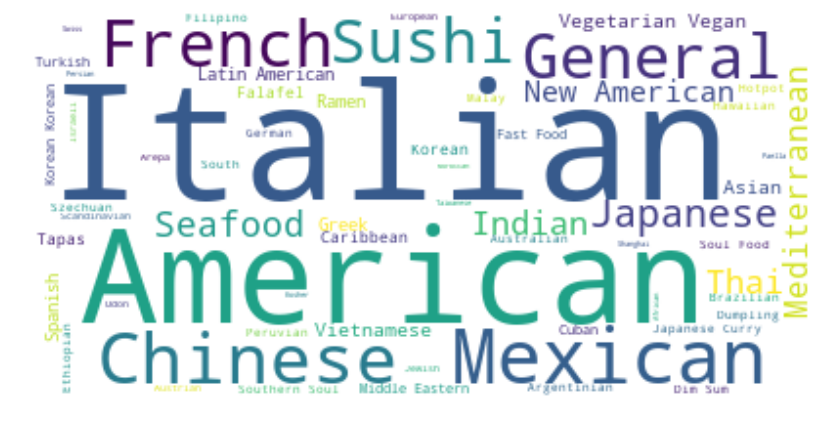

In [21]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(nyc_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Summary information of restaurants by zip code

In [22]:
nyc_restaurant.groupby('Venue Zipcode').count()

,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Category,Restaurant Type
Venue Zipcode,,,,,,,,
10001,47,47,47,47,47,47,47,47
10002,105,105,105,105,105,105,105,105
10003,85,85,85,85,85,85,85,85
10004,10,10,10,10,10,10,10,10
10005,9,9,9,9,9,9,9,9
10006,7,7,7,7,7,7,7,7
10007,24,24,24,24,24,24,24,24
10009,67,67,67,67,67,67,67,67
10010,48,48,48,48,48,48,48,48


In [23]:
print('There are {} uniques restaurant types.'.format(len(nyc_restaurant['Restaurant Type'].unique())))

There are 86 uniques restaurant types.


### One-hot encoding the zip code into restaurant types

In [24]:
# one hot encoding
manhattan_onehot = pd.get_dummies(nyc_restaurant[['Venue Zipcode']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Restaurant Type'] = nyc_restaurant['Restaurant Type'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()


,Restaurant Type,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,10012,10013,10014,10016,10017,10018,10019,10020,10021,10022,10023,10024,10025,10027,10028,10029,10030,10031,10033,10034,10036,10037,10038,10040,10044,10065,10075,10080,10118,10121,10128,10176,10280,10281,10282,10285,10463,None
3,Seafood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,American,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10,General,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,Vegetarian / Vegan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12,American,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [25]:
manhattan_onehot.shape

(1738, 49)

### Group the data by restaurant type

In [26]:
manhattan_grouped = manhattan_onehot.groupby('Restaurant Type').mean().reset_index()
manhattan_grouped.head()

,Restaurant Type,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,10012,10013,10014,10016,10017,10018,10019,10020,10021,10022,10023,10024,10025,10027,10028,10029,10030,10031,10033,10034,10036,10037,10038,10040,10044,10065,10075,10080,10118,10121,10128,10176,10280,10281,10282,10285,10463,None
0,African,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.0,0.333333,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,American,0.034965,0.034965,0.048951,0.020979,0.013986,0.006993,0.006993,0.013986,0.020979,0.027972,0.083916,0.097902,0.055944,0.069930,0.034965,0.055944,0.0,0.0,0.034965,0.041958,0.027972,0.006993,0.020979,0.013986,0.027972,0.0,0.013986,0.0,0.006993,0.013986,0.062937,0.0,0.020979,0.0,0.0,0.006993,0.013986,0.0,0.0,0.0,0.013986,0.0,0.0,0.006993,0.006993,0.0,0.013986,0.013986
2,Arepa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.250000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,Argentinian,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,Asian,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.027778,0.083333,0.055556,0.138889,0.000000,0.055556,0.083333,0.000000,0.0,0.0,0.027778,0.027778,0.000000,0.027778,0.027778,0.027778,0.027778,0.0,0.000000,0.0,0.000000,0.000000,0.055556,0.0,0.027778,0.0,0.0,0.083333,0.027778,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.055556


In [27]:
manhattan_grouped.shape

(86, 49)

### Check the most popular zip code location by restaurant types

In [28]:
num_top_zips = 3

for zc in manhattan_grouped['Restaurant Type']:
    print("----"+zc+"----")
    temp = manhattan_grouped[manhattan_grouped['Restaurant Type'] == zc].T.reset_index()
    temp.columns = ['zc','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_zips))
    print('\n')

----African ----
      zc  freq
0  10027  0.67
1  10030  0.33
2  10029  0.00


----American ----
      zc  freq
0  10013  0.10
1  10012  0.08
2  10016  0.07


----Arepa ----
      zc  freq
0  10009  0.50
1  10033  0.25
2  10011  0.25


----Argentinian ----
      zc  freq
0  10002   0.4
1  10009   0.2
2  10128   0.2


----Asian ----
      zc  freq
0  10013  0.14
1  10002  0.11
2  10065  0.08


----Australian ----
      zc  freq
0  10012  0.38
1  10003  0.12
2  10002  0.12


----Austrian ----
      zc  freq
0  10028  0.25
1  10012  0.25
2  10014  0.25


----Belgian ----
      zc  freq
0  10010   1.0
1  10001   0.0
2  10075   0.0


----Brazilian ----
      zc  freq
0  10036   0.6
1  10014   0.2
2  10128   0.2


----Cajun / Creole ----
      zc  freq
0  10002   0.5
1  10007   0.5
2  10075   0.0


----Cambodian ----
      zc  freq
0  10065   1.0
1  10001   0.0
2  10002   0.0


----Cantonese ----
      zc  freq
0  10002   1.0
1  10001   0.0
2  10030   0.0


----Caribbean ----
      zc  freq


In [29]:
def return_most_common_venues(row, num_top_zips):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_zips]

In [30]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Restaurant Type']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Zip'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Zip'.format(ind+1))

# create a new dataframe
zipcode_venues_sorted = pd.DataFrame(columns=columns)
zipcode_venues_sorted['Restaurant Type'] = manhattan_grouped['Restaurant Type']

for ind in np.arange(manhattan_grouped.shape[0]):
    zipcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

zipcode_venues_sorted.head()

,Restaurant Type,1st Most Common Zip,2nd Most Common Zip,3rd Most Common Zip,4th Most Common Zip,5th Most Common Zip
0,African,10027,10030,10025,10023,10022
1,American,10013,10012,10016,10036,10014
2,Arepa,10009,10033,10011,None,10014
3,Argentinian,10002,10128,10009,10013,None
4,Asian,10013,10002,10011,10017,10065


### Run k-means to cluster resturant types by zip code location

In [31]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Restaurant Type', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 3, 0, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 2, 4, 3, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 2, 2, 0, 3, 3, 3, 3, 2, 3, 3, 0, 3, 4, 3, 3, 1, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 2, 0, 3, 3, 1, 1, 3, 4, 3])

### Extract the most common zip by restaurant type

In [32]:
manhattan_merged = manhattan_grouped

# add clustering labels
manhattan_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(zipcode_venues_sorted.set_index('Restaurant Type'), on='Restaurant Type')
manhattan_merged = manhattan_merged[['Restaurant Type','1st Most Common Zip']]
manhattan_merged = pd.DataFrame(manhattan_merged)
manhattan_merged.head()

,Restaurant Type,1st Most Common Zip
0,African,10027
1,American,10013
2,Arepa,10009
3,Argentinian,10002
4,Asian,10013


In [33]:
manhattan_merged

,Restaurant Type,1st Most Common Zip
0,African,10027
1,American,10013
2,Arepa,10009
3,Argentinian,10002
4,Asian,10013
5,Australian,10012
6,Austrian,10028
7,Belgian,10010
8,Brazilian,10036
9,Cajun / Creole,10002


### Merge the type-zip data with restaurant information

In [34]:
venue_detail = pd.merge(manhattan_merged, nyc_restaurant, left_on=['Restaurant Type', '1st Most Common Zip'], right_on=['Restaurant Type', 'Venue Zipcode'], how='inner')
venue_detail

,Restaurant Type,1st Most Common Zip,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category
0,African,10027,Manhattan,4c2fdced452620a120551e0f,Keur Sokhna,40.813556,-73.945001,"[2249 Adam Clayton Powell Jr Blvd (133rd), New...",10027,African Restaurant
1,African,10027,Manhattan,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant,40.813728,-73.944426,[2267 7th Ave (at Adam Clayton Powell Junior B...,10027,African Restaurant
2,American,10013,Manhattan,46797032f964a520f7471fe3,Smith & Mills,40.720089,-74.009876,"[71 N Moore St (btw Greenwich & Hudson), New Y...",10013,American Restaurant
3,American,10013,Manhattan,40f1d480f964a5205b0a1fe3,Bubby's,40.720041,-74.008474,"[120 Hudson St (btwn Franklin & Moore St), New...",10013,American Restaurant
4,American,10013,Manhattan,3fd66200f964a52091e61ee3,Tribeca Grill,40.719549,-74.010234,"[375 Greenwich St (at Franklin St), New York, ...",10013,American Restaurant
5,American,10013,Manhattan,4e4190fafa762ad6d846f883,Sarabeth's,40.718152,-74.010480,"[339 Greenwich St (at Jay St), New York, NY 10...",10013,American Restaurant
6,American,10013,Manhattan,4d3f624e90f9224bef9ffc1d,David Burke Kitchen,40.722834,-74.005123,"[23 Grand St (at 6th Ave), New York, NY 10013,...",10013,American Restaurant
7,American,10013,Manhattan,557b7c4d498e8dd0400168e8,Houseman,40.725768,-74.009157,"[508 Greenwich St, New York, NY 10013, United ...",10013,American Restaurant
8,American,10013,Manhattan,43f5ac83f964a520a32f1fe3,The Hideaway,40.717440,-74.010384,"[185 Duane St (at Greenwich St), New York, NY ...",10013,American Restaurant
9,American,10013,Manhattan,57d1df42498e076195bb817c,Harold's Meat + Three,40.724521,-74.008490,"[2 Renwick St (Canal St), New York, NY 10013, ...",10013,American Restaurant


### Get the list of first restaurant by group

In [35]:
venue_first = venue_detail.groupby(['Restaurant Type','1st Most Common Zip']).first()
venue_first

,,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category
Restaurant Type,1st Most Common Zip,,,,,,,,
African,10027,Manhattan,4c2fdced452620a120551e0f,Keur Sokhna,40.813556,-73.945001,"[2249 Adam Clayton Powell Jr Blvd (133rd), New...",10027,African Restaurant
American,10013,Manhattan,46797032f964a520f7471fe3,Smith & Mills,40.720089,-74.009876,"[71 N Moore St (btw Greenwich & Hudson), New Y...",10013,American Restaurant
Arepa,10009,Manhattan,41229c00f964a520350c1fe3,Caracas Arepa Bar,40.726846,-73.985468,"[91 E 7th St (btw 1st & Ave A), New York, NY 1...",10009,Arepa Restaurant
Argentinian,10002,Manhattan,53e02d67498e78c091589343,Balvanera,40.720547,-73.985399,"[152 Stanton St (Suffolk St.), New York, NY 10...",10002,Argentinian Restaurant
Asian,10013,Manhattan,4a75edcff964a520b3e11fe3,Wild Ginger Vegetarian Kitchen,40.720431,-73.996640,"[380 Broome St (at Mulberry St.), New York, NY...",10013,Asian Restaurant
Australian,10012,Manhattan,5748b645498e423eddab64ec,Coco & Cru,40.726654,-73.995926,"[643 Broadway (at Bleeker St), New York, NY 10...",10012,Australian Restaurant
Austrian,10028,Manhattan,56d92b51cd10b39f863823c2,Grünauer Bistro,40.774356,-73.951192,"[1578 1st Ave, New York, NY 10028, United States]",10028,Austrian Restaurant
Belgian,10010,Manhattan,49e3b1dff964a520b7621fe3,Petite Abeille,40.734974,-73.979608,"[401 E 20th St (at 1st Ave.), New York, NY 100...",10010,Belgian Restaurant
Brazilian,10036,Manhattan,57671bd4498e7856b7d79963,Samba Kitchen & Bar,40.760845,-73.990896,"[661 9th Ave (46 st), Manhattan, NY 10036, Uni...",10036,Brazilian Restaurant


### Extract the customer rating of restaurant from Foursquare API

In [36]:
def getRating(ids):
    
    rating_list=[]
    counter = 0
    
    for ID in ids:
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(ID, CLIENT_ID, CLIENT_SECRET, VERSION)
        results = requests.get(url).json()
        
        try:
            rating = results['response']['venue']['rating']
        except:
            rating = 'None'
        
        rating_list.append([ID, rating])
        
        counter += 1
        print('{}.'.format(counter),ID,rating)
                     
    return(rating_list)

In [37]:
nyc_rating = getRating(ids=venue_first['Venue ID'])

1. 4c2fdced452620a120551e0f 7.5
2. 46797032f964a520f7471fe3 8.7
3. 41229c00f964a520350c1fe3 9.1
4. 53e02d67498e78c091589343 8.8
5. 4a75edcff964a520b3e11fe3 8.8
6. 5748b645498e423eddab64ec 8.2
7. 56d92b51cd10b39f863823c2 6.8
8. 49e3b1dff964a520b7621fe3 7.5
9. 57671bd4498e7856b7d79963 8.1
10. 528eab6a11d24cd6c6e034fa 7.9
11. 5697eb99498e2c0506556900 8.5
12. 547622dd498eaea3be8a559f 7.6
13. 4ad65ad3f964a520ba0621e3 6.8
14. 5b2d2f56911fc4002cd86b15 8.5
15. 5894c9a15e56b417cf79e553 9.0
16. 5941499cee628b053856aed1 7.4
17. 4ce5648a5fce5481ba5e5baa 9.1
18. 57116e43498ea9ddf52b2b60 8.0
19. 3fd66200f964a520d5e31ee3 8.4
20. 49eeaf08f964a52078681fe3 9.0
21. 4eb5bf5a722e578a4f99db28 None
22. 563ac375498ed9576b893e79 8.7
23. 4c9d482e46978cfa8247967f 8.8
24. 4e7384b7fa76812398e4295b 6.5
25. 3fd66200f964a5202ee61ee3 9.1
26. 5b8041d835811b002c7d040b 8.3
27. 503f293c19a9def238a153b3 8.8
28. 5abc33ccad17896edaca3d61 9.3
29. 5a0264e01ffe977e0fea5da3 7.0
30. 439e1fd8f964a520092c1fe3 8.9
31. 54998557498ea2

### Keep only restaurants with rating

In [38]:
nyc_rating = pd.DataFrame(nyc_rating)
nyc_rating.columns = ['Venue ID', 'Venue Rating']
nyc_rating.head()

,Venue ID,Venue Rating
0,4c2fdced452620a120551e0f,7.5
1,46797032f964a520f7471fe3,8.7
2,41229c00f964a520350c1fe3,9.1
3,53e02d67498e78c091589343,8.8
4,4a75edcff964a520b3e11fe3,8.8


In [39]:
nyc_rating_good = nyc_rating[nyc_rating['Venue Rating'] != 'None']
nyc_rating_good

,Venue ID,Venue Rating
0,4c2fdced452620a120551e0f,7.5
1,46797032f964a520f7471fe3,8.7
2,41229c00f964a520350c1fe3,9.1
3,53e02d67498e78c091589343,8.8
4,4a75edcff964a520b3e11fe3,8.8
5,5748b645498e423eddab64ec,8.2
6,56d92b51cd10b39f863823c2,6.8
7,49e3b1dff964a520b7621fe3,7.5
8,57671bd4498e7856b7d79963,8.1
9,528eab6a11d24cd6c6e034fa,7.9


### Construct final sample by merging

In [54]:
dataset = pd.merge(venue_detail, nyc_rating_good, on='Venue ID', how='inner')
dataset.rename(columns={'Restaurant Type' : 'Type', '1st Most Common Zip': 'Postcode'}, inplace=True)
dataset

,Type,Postcode,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category,Venue Rating
0,African,10027,Manhattan,4c2fdced452620a120551e0f,Keur Sokhna,40.813556,-73.945001,"[2249 Adam Clayton Powell Jr Blvd (133rd), New...",10027,African Restaurant,7.5
1,American,10013,Manhattan,46797032f964a520f7471fe3,Smith & Mills,40.720089,-74.009876,"[71 N Moore St (btw Greenwich & Hudson), New Y...",10013,American Restaurant,8.7
2,Arepa,10009,Manhattan,41229c00f964a520350c1fe3,Caracas Arepa Bar,40.726846,-73.985468,"[91 E 7th St (btw 1st & Ave A), New York, NY 1...",10009,Arepa Restaurant,9.1
3,Argentinian,10002,Manhattan,53e02d67498e78c091589343,Balvanera,40.720547,-73.985399,"[152 Stanton St (Suffolk St.), New York, NY 10...",10002,Argentinian Restaurant,8.8
4,Argentinian,10002,Manhattan,53e02d67498e78c091589343,Balvanera,40.720547,-73.985399,"[152 Stanton St (Suffolk St.), New York, NY 10...",10002,Argentinian Restaurant,8.8
5,Asian,10013,Manhattan,4a75edcff964a520b3e11fe3,Wild Ginger Vegetarian Kitchen,40.720431,-73.996640,"[380 Broome St (at Mulberry St.), New York, NY...",10013,Asian Restaurant,8.8
6,Asian,10013,Manhattan,4a75edcff964a520b3e11fe3,Wild Ginger Vegetarian Kitchen,40.720431,-73.996640,"[380 Broome St (at Mulberry St.), New York, NY...",10013,Asian Restaurant,8.8
7,Australian,10012,Manhattan,5748b645498e423eddab64ec,Coco & Cru,40.726654,-73.995926,"[643 Broadway (at Bleeker St), New York, NY 10...",10012,Australian Restaurant,8.2
8,Austrian,10028,Manhattan,56d92b51cd10b39f863823c2,Grünauer Bistro,40.774356,-73.951192,"[1578 1st Ave, New York, NY 10028, United States]",10028,Austrian Restaurant,6.8
9,Belgian,10010,Manhattan,49e3b1dff964a520b7621fe3,Petite Abeille,40.734974,-73.979608,"[401 E 20th St (at 1st Ave.), New York, NY 100...",10010,Belgian Restaurant,7.5


In [58]:

# dropping ALL duplicte values 
dataset.drop_duplicates(subset ="Venue ID", keep = False, inplace = True) 
dataset

,Type,Postcode,Borough,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Address,Venue Zipcode,Venue Category,Venue Rating
0,African,10027,Manhattan,4c2fdced452620a120551e0f,Keur Sokhna,40.813556,-73.945001,"[2249 Adam Clayton Powell Jr Blvd (133rd), New...",10027,African Restaurant,7.5
1,American,10013,Manhattan,46797032f964a520f7471fe3,Smith & Mills,40.720089,-74.009876,"[71 N Moore St (btw Greenwich & Hudson), New Y...",10013,American Restaurant,8.7
2,Arepa,10009,Manhattan,41229c00f964a520350c1fe3,Caracas Arepa Bar,40.726846,-73.985468,"[91 E 7th St (btw 1st & Ave A), New York, NY 1...",10009,Arepa Restaurant,9.1
7,Australian,10012,Manhattan,5748b645498e423eddab64ec,Coco & Cru,40.726654,-73.995926,"[643 Broadway (at Bleeker St), New York, NY 10...",10012,Australian Restaurant,8.2
8,Austrian,10028,Manhattan,56d92b51cd10b39f863823c2,Grünauer Bistro,40.774356,-73.951192,"[1578 1st Ave, New York, NY 10028, United States]",10028,Austrian Restaurant,6.8
9,Belgian,10010,Manhattan,49e3b1dff964a520b7621fe3,Petite Abeille,40.734974,-73.979608,"[401 E 20th St (at 1st Ave.), New York, NY 100...",10010,Belgian Restaurant,7.5
10,Brazilian,10036,Manhattan,57671bd4498e7856b7d79963,Samba Kitchen & Bar,40.760845,-73.990896,"[661 9th Ave (46 st), Manhattan, NY 10036, Uni...",10036,Brazilian Restaurant,8.1
11,Cajun / Creole,10002,Manhattan,528eab6a11d24cd6c6e034fa,Claw Daddy's,40.722033,-73.988246,"[185 Orchard St (btwn Stanton and Houston St),...",10002,Cajun / Creole Restaurant,7.9
12,Cambodian,10065,Manhattan,5697eb99498e2c0506556900,Angkor Cambodian Bistro NYC,40.762471,-73.959103,"[408 E 64th St, New York, NY 10065, United Sta...",10065,Cambodian Restaurant,8.5
13,Cantonese,10002,Manhattan,547622dd498eaea3be8a559f,Kings Kitchen 金煌煲煲好,40.713852,-73.993640,"[92 E Broadway, New York, NY 10002, United Sta...",10002,Cantonese Restaurant,7.6


In [63]:
dataset.shape

(67, 11)

In [65]:
len(dataset['Type'].unique())

67

### Visualize the selected restaurants

In [62]:
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
# add the trending venues as blue circle markers
for v1, v2, v3, v4, v5, v6 in zip(dataset['Venue Latitude'], dataset['Venue Longitude'], dataset['Venue'], dataset['Type'], dataset['Postcode'], dataset['Venue Rating']):
        label = v3 + " "+ v4 + "" + str(v6) 
        print(label)
        label = folium.Popup(label, parse_html=True)
        folium.features.CircleMarker(
        [v1, v2],
        radius=1,
        poup=label,
        fill=False,
        color='red',
        fill_opacity=0.3).add_to(map_manhattan)
    

Keur Sokhna African 7.5
Smith & Mills American 8.7
Caracas Arepa Bar Arepa 9.1
Coco & Cru Australian 8.2
Grünauer Bistro Austrian 6.8
Petite Abeille Belgian 7.5
Samba Kitchen & Bar Brazilian 8.1
Claw Daddy's Cajun / Creole 7.9
Angkor Cambodian Bistro NYC Cambodian 8.5
Kings Kitchen 金煌煲煲好 Cantonese 7.6
Golden Krust Caribbean Bakery and Grill Caribbean 6.8
Xi'an Famous Foods Chinese 9.0
Chirping Chicken Comfort Food 7.4
Sophie's Cuban Cuisine Cuban 9.1
Bohemian Spirit Restaurant Czech 8.0
Jing Fong Restaurant 金豐大酒樓 Dim Sum 8.4
Vanessa's Dumpling House Dumpling 9.0
Empanada Mama Empanada 8.7
The Fat Radish English 8.8
Massawa Ethiopian 6.5
Mamoun's Falafel Falafel 9.1
Taïm Fast Food 8.3
Jeepney Filipino Gastropub Filipino 8.8
Heidelberg Restaurant German 8.9
Senza Gluten Gluten-free 8.1
Chola Eclectic Indian Cuisine Indian 8.6
Nur Israeli 8.8
Bar Ciccio Alimentari Italian 9.0
Morimoto Japanese 9.2
Go! Go! Curry! Japanese Curry 7.4
Jongro BBQ Korean 9.3
El Castillo De Jagua II Latin Americ

In [61]:
map_manhattan